In [1]:
from datetime import date
from enum import Enum

%load_ext google.cloud.bigquery
from google.cloud import bigquery

import pandas as pd
import numpy as np
import plotly as py

In [2]:
project = "celo-testnet"
client = bigquery.Client(project)
for dataset in client.list_datasets():
    print(dataset.dataset_id)

dataflow_metrics
load_test_data
segment_data
segment_data_events
segment_data_metrics
tme_test_stakeoff
transaction_data
transaction_metrics_exporter


In [3]:
partition = date.today().strftime("%Y%m%d")
# partition = 20200325
partition = "*"
dataset = "transaction_metrics_exporter"
table = "transaction_metrics_exporter_{0}".format(partition)

dataset = "tme_test_stakeoff"
table = "tme_stakeoff_test_{0}".format(partition)

tme = client.get_dataset(dataset)
table_path = ".".join([project, dataset, table])
print(table_path)

window_min = 130700
window_max = 130900

celo-testnet.tme_test_stakeoff.tme_stakeoff_test_*


In [4]:
class EventTypes(Enum):
    RECEIVED_BLOCK="RECEIVED_BLOCK"
    RECEIVED_STATE="RECEIVED_STATE"
    RECEIVED_TRANSACTION="RECEIVED_TRANSACTION"
    RECEIVED_TRANSACTION_RECEIPT="RECEIVED_TRANSACTION_RECEIPT"
    RECEIVED_PARSED_TRANSACTION="RECEIVED_PARSED_TRANSACTION"
    RECEIVED_PARSED_LOG="RECEIVED_PARSED_LOG"

In [5]:
query_blocks = f"""
SELECT 
  MAX(T.jsonPayload.timestamp) as timestamp,
  T.jsonPayload.number as blockNumber,
  MAX(T.jsonPayload.gasUsed) as gasUsed,
  MAX(T.jsonPayload.gasLimit) as gasLimit,
  COUNT(T.jsonPayload.transactions) as txAmount
FROM 
  `{table_path}` as T
WHERE
   T.jsonPayload.event='{EventTypes.RECEIVED_BLOCK.value}' and
   T.jsonPayload.number >= {window_min} and
   T.jsonPayload.number <= {window_max}
GROUP BY blockNumber
ORDER BY blockNumber DESC 
"""

df_blocks = client.query(
    query_blocks, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_blocks['blocktime'] = df_blocks[::-1].diff(axis=0).timestamp
df_blocks = df_blocks
df_blocks.describe()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
count,1.850000e+02,185.000000,185.000000,185.0,185.000000,184.000000
mean,1.579356e+09,130804.805405,144638.210811,20000000.0,1.064865,5.434783
std,2.884731e+02,57.694614,90309.177295,0.0,0.398514,3.556889
min,1.579356e+09,130700.000000,0.000000,20000000.0,1.000000,5.000000
25%,1.579356e+09,130754.000000,82138.000000,20000000.0,1.000000,5.000000
50%,1.579356e+09,130808.000000,132138.000000,20000000.0,1.000000,5.000000
75%,1.579356e+09,130854.000000,182138.000000,20000000.0,1.000000,5.000000
max,1.579357e+09,130900.000000,539225.000000,20000000.0,4.000000,45.000000


In [6]:
df_blocks.head()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
0,1.579357e+09,130900.0,41069.0,20000000.0,4,5.0
1,1.579357e+09,130899.0,170432.0,20000000.0,1,5.0
2,1.579357e+09,130898.0,149795.0,20000000.0,1,5.0
3,1.579357e+09,130897.0,169775.0,20000000.0,1,5.0
4,1.579357e+09,130896.0,29363.0,20000000.0,1,5.0


last block  : 130900 on 1579356605.0
first block : 130700 on 1579355605.0
blocks load : 185
transactions: 197
mean gasUsed: 144638 GcWei
mean blocktime: 5.4 s


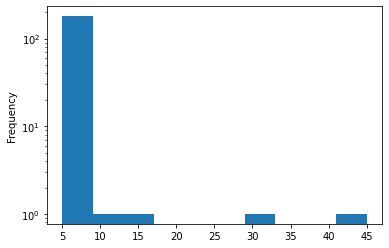

In [7]:
last_block, first_block = df_blocks.blockNumber.max(), df_blocks.blockNumber.min()
print(f"last block  : {last_block:.0f} on {df_blocks.timestamp.max()}") 
print(f"first block : {first_block:.0f} on {df_blocks.timestamp.min()}")
print(f"blocks load : {df_blocks.timestamp.count():.0f}")
print(f"transactions: {df_blocks.txAmount.sum()}")
print(f"mean gasUsed: {df_blocks.gasUsed.mean():.0f} GcWei")
df_blocks.blocktime.plot.hist(logy=True)
print(f"mean blocktime: {df_blocks.blocktime.mean():.1f} s")

In [8]:
query_state = f"""
SELECT
  timestamp,
  jsonPayload.blockNumber,
  jsonPayload.values.rewardsamount,
  jsonPayload.values.rewardsmultiplier,
  jsonPayload.values.medianRate,
  jsonPayload.values.currentStableBucket,
  jsonPayload.values.currentGoldBucket,
  jsonPayload.values.goldTokenTotalSupply
FROM 
  `{table_path}` as T
WHERE 
  jsonPayload.event='{EventTypes.RECEIVED_STATE.value}' and
  jsonPayload.blockNumber >= {window_min} and
  jsonPayload.blockNumber <= {window_max}
ORDER BY 
  T.jsonPayload.blockNumber DESC,
  T.timestamp DESC
"""

df_state = client.query(
    query_state, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_state = df_state \
    .groupby('blockNumber').max() \
    .merge(df_blocks, left_on='blockNumber', right_on='blockNumber', suffixes=('_tme', '_block'))
df_state['datetime_block'] = pd.to_datetime(df_state['timestamp_block'],unit='s')
df_state[['currentStableBucket','currentGoldBucket']] = df_state[['currentStableBucket','currentGoldBucket']].astype('float')

df_state.describe()

,blockNumber,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime
count,185.000000,1.850000e+02,1.850000e+02,185.000,1.850000e+02,1.850000e+02,1.850000e+02,1.850000e+02,185.000000,185.0,185.000000,184.000000
mean,130804.805405,6.002783e+26,1.614589e+24,0.999,9.986516e+23,9.975608e+23,1.089266e+26,1.579356e+09,144638.210811,20000000.0,1.064865,5.434783
std,57.694614,1.219656e+20,3.400905e+17,0.000,7.136097e+20,7.037463e+20,0.000000e+00,2.884731e+02,90309.177295,0.0,0.398514,3.556889
min,130700.000000,6.002781e+26,1.614589e+24,0.999,9.975851e+23,9.966155e+23,1.089266e+26,1.579356e+09,0.000000,20000000.0,1.000000,5.000000
25%,130754.000000,6.002782e+26,1.614589e+24,0.999,9.985851e+23,9.966155e+23,1.089266e+26,1.579356e+09,82138.000000,20000000.0,1.000000,5.000000
50%,130808.000000,6.002783e+26,1.614589e+24,0.999,9.986149e+23,9.976085e+23,1.089266e+26,1.579356e+09,132138.000000,20000000.0,1.000000,5.000000
75%,130854.000000,6.002784e+26,1.614589e+24,0.999,9.996049e+23,9.976185e+23,1.089266e+26,1.579356e+09,182138.000000,20000000.0,1.000000,5.000000
max,130900.000000,6.002785e+26,1.614590e+24,0.999,9.996049e+23,9.986135e+23,1.089266e+26,1.579357e+09,539225.000000,20000000.0,4.000000,45.000000


In [9]:
df_state.tail()

,blockNumber,timestamp_tme,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
180,130896.0,2020-03-26 08:32:28.341344+00:00,6.002785e+26,1.614590e+24,0.999,9.985851e+23,9.975886e+23,1.089266e+26,1.579357e+09,29363.0,20000000.0,1,5.0,2020-01-18 14:09:45
181,130897.0,2020-03-26 08:32:28.792289+00:00,6.002785e+26,1.614590e+24,0.999,9.985851e+23,9.975886e+23,1.089266e+26,1.579357e+09,169775.0,20000000.0,1,5.0,2020-01-18 14:09:50
182,130898.0,2020-03-26 08:32:29.547629+00:00,6.002785e+26,1.614590e+24,0.999,9.985851e+23,9.975886e+23,1.089266e+26,1.579357e+09,149795.0,20000000.0,1,5.0,2020-01-18 14:09:55
183,130899.0,2020-03-26 08:32:30.299727+00:00,6.002785e+26,1.614590e+24,0.999,9.985851e+23,9.975886e+23,1.089266e+26,1.579357e+09,170432.0,20000000.0,1,5.0,2020-01-18 14:10:00
184,130900.0,2020-03-26 08:32:30.902963+00:00,6.002785e+26,1.614590e+24,0.999,9.985851e+23,9.975886e+23,1.089266e+26,1.579357e+09,41069.0,20000000.0,4,5.0,2020-01-18 14:10:05


Text(0, 0.5, 'SortedOracles.medianRate')

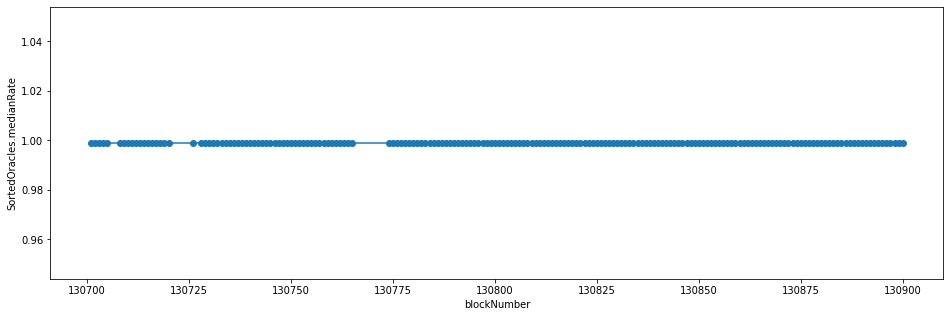

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 5]
df_slice = df_state[1:]
df_sortedOracles = df_slice.set_index('blockNumber')['medianRate']
ax = df_sortedOracles.plot(marker='o')
ax.set_ylabel("SortedOracles.medianRate")

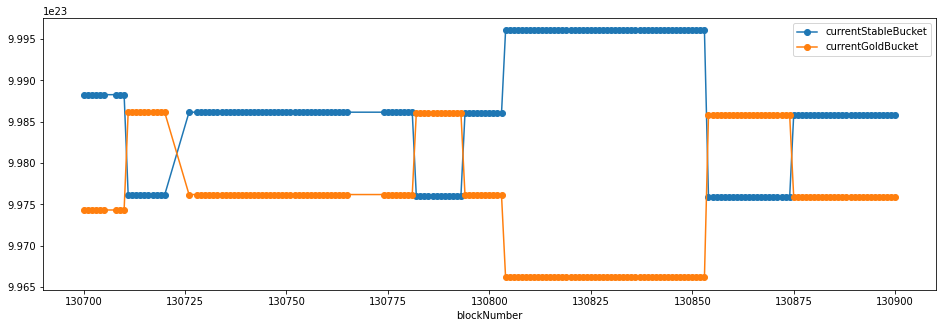

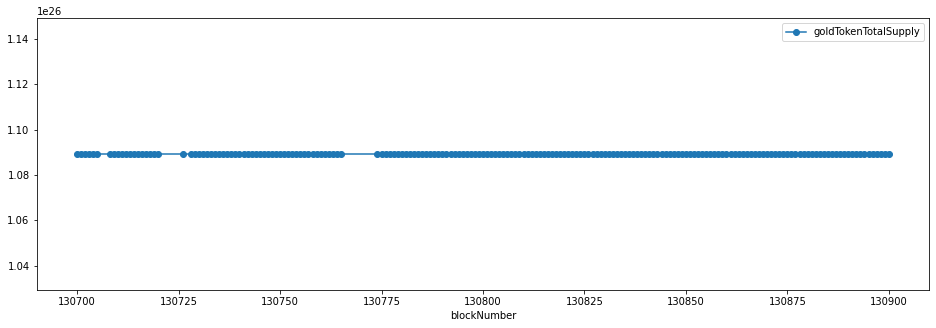

In [11]:
df_stableToken = df_state.set_index('blockNumber')[['currentStableBucket']]
ax = df_stableToken.plot(marker='o')
# df_stableToken[df_stableToken<2e24].plot(marker='o')
df_goldbucket = df_state.set_index('blockNumber')[['currentGoldBucket']]
df_goldbucket.plot(marker='o', ax=ax)
df_goldToken = df_state.set_index('blockNumber')[['goldTokenTotalSupply']]
df_goldToken.plot(marker='o')

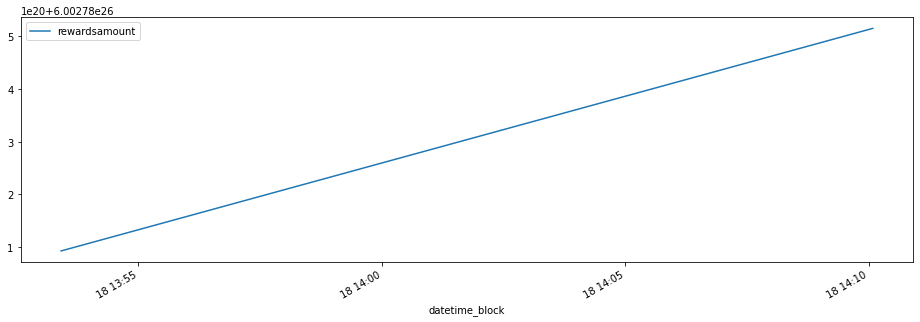

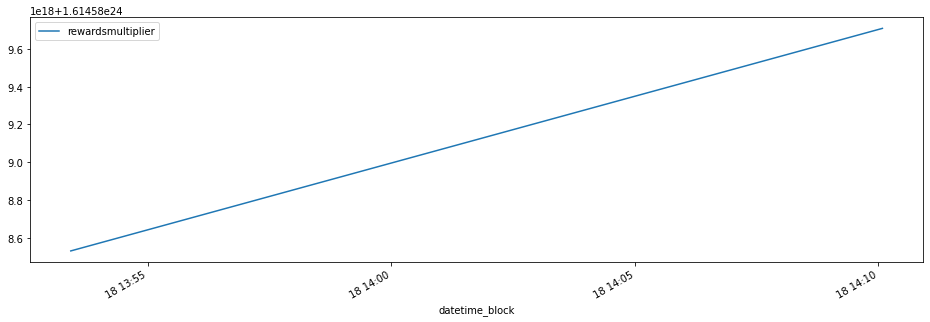

In [12]:
df_rewardsAmount = df_state.set_index('datetime_block')[['rewardsamount']]
ax = df_rewardsAmount.plot()
df_rewardsMultiplier = df_state.set_index('datetime_block')[['rewardsmultiplier']]
ax = df_rewardsMultiplier.plot()

In [13]:
query_events = f"""
SELECT
  jsonPayload.blockNumber as blockNumber,
  jsonPayload.returnValues,
  jsonPayload.address,
  jsonPayload.eventName
FROM 
  `{table_path}` as T
WHERE 
  jsonPayload.event='{EventTypes.RECEIVED_PARSED_LOG.value}' and
  jsonPayload.blockNumber >= {window_min} and
  jsonPayload.blockNumber <= {window_max}
ORDER BY 
  blockNumber DESC
"""

df_events = client.query(
    query_events, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_events = pd.concat([
    df_events.drop(['returnValues'], axis=1), 
    df_events['returnValues'].apply(pd.Series)
], axis=1)

df_events[['buyamount','sellamount']] = df_events[['buyamount','sellamount']].astype('float')
df_events = df_events.merge(df_state, left_on='blockNumber', right_on='blockNumber')
df_events.describe()

,blockNumber,sellamount,buyamount,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime
count,465.000000,9.000000e+00,9.000000e+00,4.650000e+02,4.650000e+02,4.650000e+02,4.650000e+02,4.650000e+02,4.650000e+02,4.650000e+02,465.000000,465.0,465.000000,441.000000
mean,130800.075269,7.777778e+20,7.734943e+20,6.002783e+26,1.614589e+24,9.990000e-01,9.986639e+23,9.975504e+23,1.089266e+26,1.579356e+09,186230.346237,20000000.0,1.318280,5.521542
std,60.153116,4.409586e+20,4.385304e+20,1.271629e+20,3.545825e+17,2.222837e-16,6.677930e+20,6.580268e+20,0.000000e+00,3.007656e+02,101493.172756,0.0,0.886798,3.807900
min,130700.000000,0.000000e+00,0.000000e+00,6.002781e+26,1.614589e+24,9.990000e-01,9.975851e+23,9.966155e+23,1.089266e+26,1.579356e+09,29363.000000,20000000.0,1.000000,5.000000
25%,130747.000000,1.000000e+21,9.930178e+20,6.002782e+26,1.614589e+24,9.990000e-01,9.985851e+23,9.974316e+23,1.089266e+26,1.579356e+09,120432.000000,20000000.0,1.000000,5.000000
50%,130800.000000,1.000000e+21,9.946060e+20,6.002783e+26,1.614589e+24,9.990000e-01,9.986149e+23,9.976085e+23,1.089266e+26,1.579356e+09,169775.000000,20000000.0,1.000000,5.000000
75%,130852.000000,1.000000e+21,9.946060e+20,6.002784e+26,1.614589e+24,9.990000e-01,9.988268e+23,9.976185e+23,1.089266e+26,1.579356e+09,211501.000000,20000000.0,1.000000,5.000000
max,130900.000000,1.000000e+21,9.950036e+20,6.002785e+26,1.614590e+24,9.990000e-01,9.996049e+23,9.986135e+23,1.089266e+26,1.579357e+09,539225.000000,20000000.0,4.000000,45.000000


In [14]:
df_events.head()

,blockNumber,address,eventName,identifier,addr,identifierhash,slasheridentifier,account,metadataurl,value,...,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
0,130900.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.985851e+23,9.975886e+23,1.089266e+26,1.579357e+09,41069.0,20000000.0,4,5.0,2020-01-18 14:10:05
1,130900.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.985851e+23,9.975886e+23,1.089266e+26,1.579357e+09,41069.0,20000000.0,4,5.0,2020-01-18 14:10:05
2,130900.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.985851e+23,9.975886e+23,1.089266e+26,1.579357e+09,41069.0,20000000.0,4,5.0,2020-01-18 14:10:05
3,130900.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.985851e+23,9.975886e+23,1.089266e+26,1.579357e+09,41069.0,20000000.0,4,5.0,2020-01-18 14:10:05
4,130899.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.985851e+23,9.975886e+23,1.089266e+26,1.579357e+09,170432.0,20000000.0,1,5.0,2020-01-18 14:10:00


In [15]:
df_events.groupby('eventName').eventName.count().sort_values(ascending=False)

eventName
Transfer                     427
Approval                      26
Exchanged                      9
AttestationsRequested          2
AttestationIssuerSelected      1
Name: eventName, dtype: int64

In [16]:
df_exchange = df_events[df_events.eventName == "Exchanged"].set_index('blockNumber')[['exchanger', 'buyamount', 'sellamount', 'soldgold']]
df_exchange.groupby('exchanger').exchanger.count().sort_values(ascending=False)

exchanger
0x8fb800b94D2b1258236E598FCd5e65eAf45CA671    7
0xd6F05649c5350c20030de1dC57eD31510141F487    1
0x73b49DA41223585a650712363BA7878Ed60a964d    1
Name: exchanger, dtype: int64

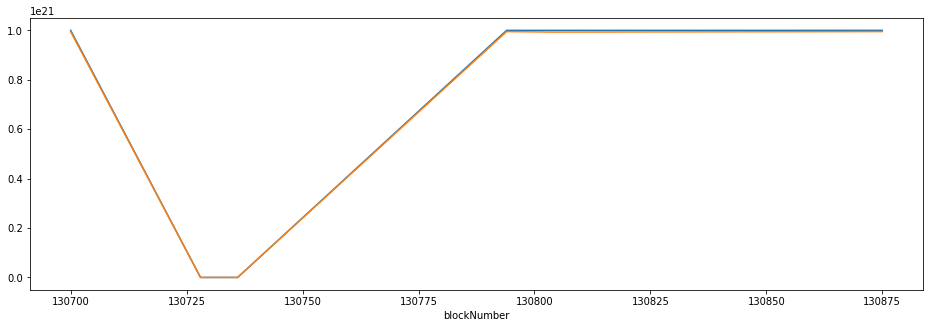

In [17]:
(df_exchange['sellamount']).plot()
(df_exchange['buyamount']).plot()

exchanger     0
buyamount     0
sellamount    0
soldgold      0
dtype: int64


exchanger     9
buyamount     9
sellamount    9
soldgold      9
dtype: int64

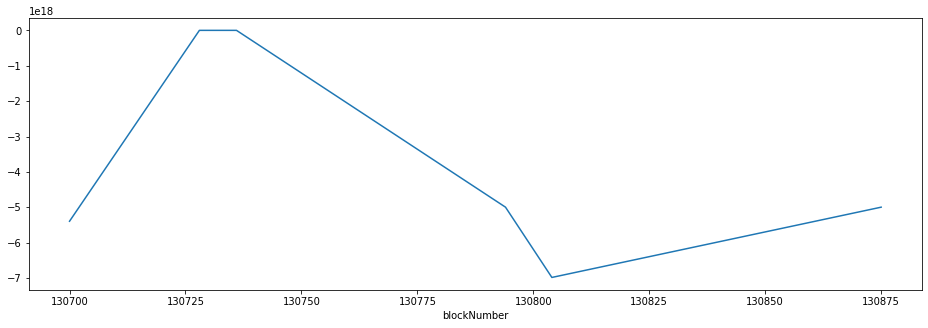

In [18]:
# difference
(df_exchange['buyamount']-df_exchange['sellamount']).plot()
print(df_exchange[df_exchange.soldgold].count())
df_exchange[df_exchange.soldgold == False].count()


In [19]:
df_ex = df_events.set_index('blockNumber')[['buyamount', 'sellamount', 'currentStableBucket', 'currentGoldBucket', 'soldgold']]
df_ex = df_ex[df_ex.buyamount.notna()]

Text(0, 0.5, 'currentGoldBucket')

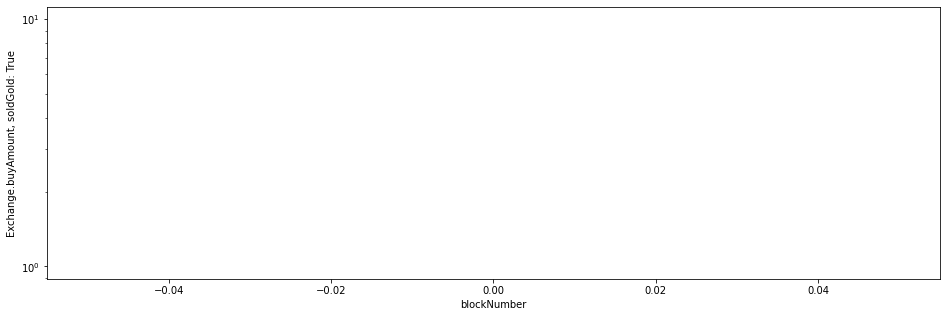

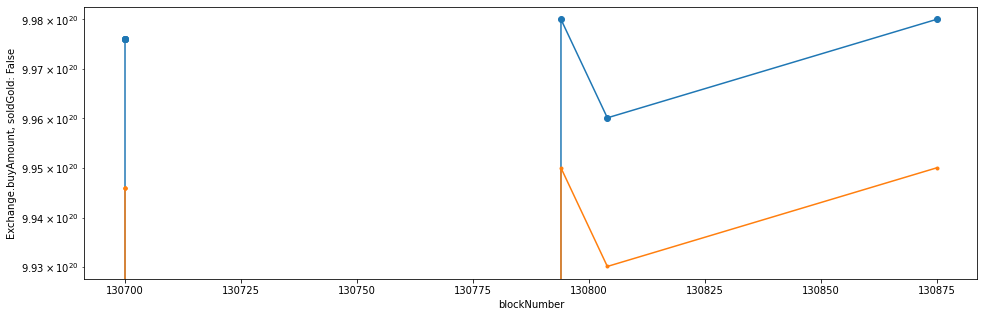

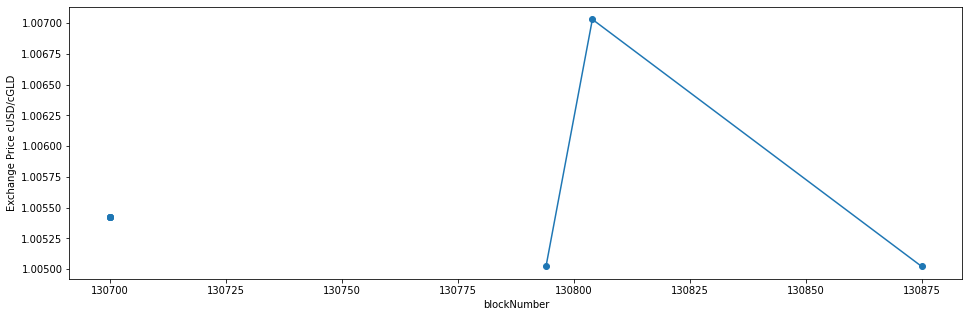

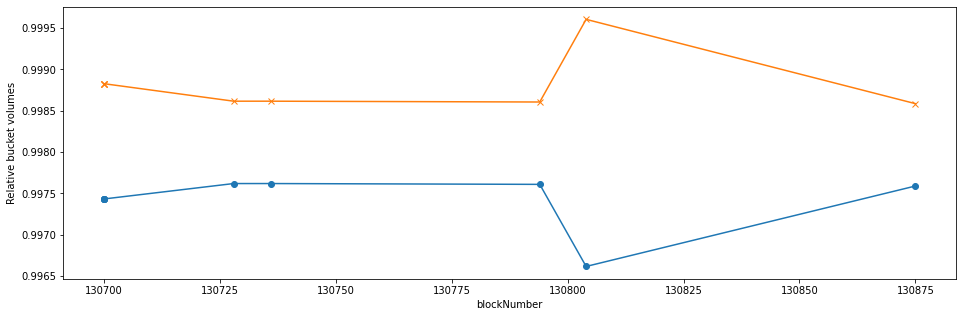

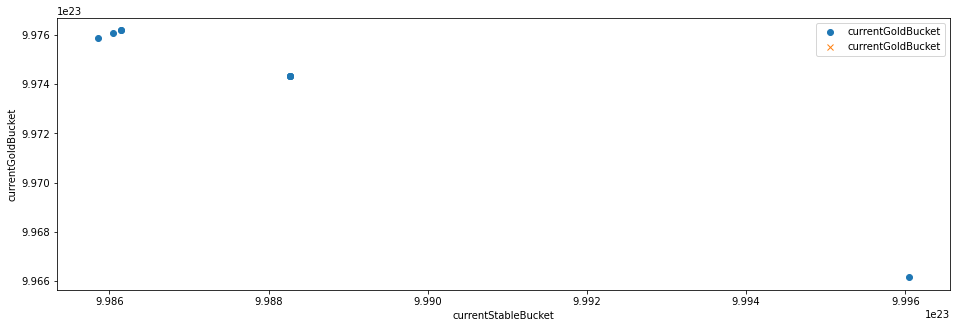

In [20]:
def estimate_buyamount(soldGold):
    df_buy = df_ex[df_ex.soldgold == soldGold]
    Ab = df_buy.buyamount
    As = df_buy.sellamount
    Bs = df_buy.currentStableBucket
    Bg = df_buy.currentGoldBucket
    Bbuy = Bs if soldGold else Bg
    Bsell = Bg if soldGold else Bs

    # buyamount computation is
    # Asell = (1-spread)*As
    # Abuy = Asell/(Bsell+Asell)*Bbuy
    spread = 0
    Asell = (1-spread)*As
    Abuy_hat = Asell/(Bsell+Asell)*Bbuy
    # Abuy_hat = Asell/(Bsell)*Bbuy
    
    return df_buy, Abuy_hat, Bbuy, Bsell


soldGold = True
df_buy_sellgold, Abuy_hat_sellgold, Bbuy_sellgold, Bsell_sellgold = estimate_buyamount(soldGold)
ax = Abuy_hat_sellgold.plot(marker='o')
ax.set_ylabel(f"Exchange.buyAmount, soldGold: {soldGold}")
df_buy_sellgold.buyamount.plot(marker='.')
(df_buy_sellgold.buyamount - Abuy_hat_sellgold).plot(marker='x', logy=True)

soldGold = False
df_buy_sellusd, Abuy_hat_sellusd, Bbuy_sellusd, Bsell_sellusd = estimate_buyamount(False)
plt.figure()
ax = Abuy_hat_sellusd.plot(marker='o')
ax.set_ylabel(f"Exchange.buyAmount, soldGold: {soldGold}")
df_buy_sellusd.buyamount.plot(marker='.')
(df_buy_sellusd.buyamount - Abuy_hat_sellusd).plot(marker='x', logy=True)

plt.figure()
ax = (df_buy_sellusd.sellamount/df_buy_sellusd.buyamount).plot(marker='o')
(df_buy_sellgold.buyamount/df_buy_sellgold.sellamount).plot(marker='x')
ax.set_ylabel(f"Exchange Price cUSD/cGLD")

plt.figure()
ax = (df_buy_sellusd.currentGoldBucket/1e24).plot(marker='o')
(df_buy_sellusd.currentStableBucket/1e24).plot(marker='x')
ax.set_ylabel(f"Relative bucket volumes")

fig, ax = plt.subplots(1, 1)
df_buy_sellusd.plot(x='currentStableBucket', y='currentGoldBucket', style='o', ax=ax)
df_buy_sellgold.plot(x='currentStableBucket', y='currentGoldBucket', style='x', ax=ax)
ax.set_ylabel(f"currentGoldBucket")

In [21]:
df_goldlocked = df_events[df_events.eventName == "GoldLocked"].set_index('blockNumber')[['account', 'value']]
df_goldlocked[['value']] = df_goldlocked[['value']].astype('float')
df_goldlocked.groupby('account').value.sum().sort_values(ascending=False)
df_goldlocked[df_goldlocked.account == "0x775a5C899Fd4A7CDD54e9f41738087748CfcB953"].groupby('account').value.sum().sort_values(ascending=False)

Series([], Name: value, dtype: float64)

In [22]:
query_receipt=f"""
WITH logQuery AS (
  SELECT 
    T.jsonPayload.blockNumber as blockNumber,
    T.jsonPayload.from,
    log
  FROM 
    `{table_path}` as T
  CROSS JOIN UNNEST(T.jsonPayload.logs) as log
  WHERE 
    T.jsonPayload.event='{EventTypes.RECEIVED_TRANSACTION_RECEIPT.value}' and
    T.jsonPayload.blockNumber >= {window_min} and
    T.jsonPayload.blockNumber <= {window_max}
ORDER BY blockNumber DESC)
SELECT
  l.blockNumber,
  l.from,
  l.log.address,
  topic
FROM logQuery as l
CROSS JOIN UNNEST(l.log.topics) as topic;
"""

df_receipt = client.query(
    query_receipt, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
)
df_receipt = df_receipt.to_dataframe()

In [23]:
df_receipt.head()

,blockNumber,from,address,topic
0,130900.0,0xed1ed9a71e313d1bce14ab998e0646f212230a33,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...
1,130900.0,0xed1ed9a71e313d1bce14ab998e0646f212230a33,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0x000000000000000000000000ed1ed9a71e313d1bce14...
2,130900.0,0xed1ed9a71e313d1bce14ab998e0646f212230a33,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0x000000000000000000000000c563f264f98e34a409c6...
3,130900.0,0xed1ed9a71e313d1bce14ab998e0646f212230a33,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...
4,130900.0,0xed1ed9a71e313d1bce14ab998e0646f212230a33,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0x000000000000000000000000ed1ed9a71e313d1bce14...


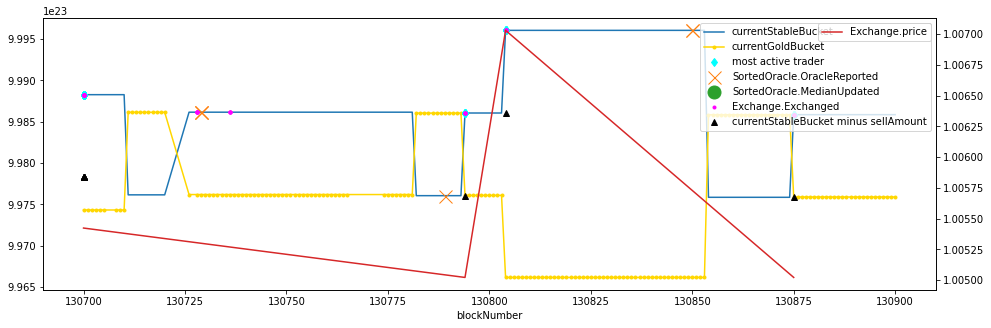

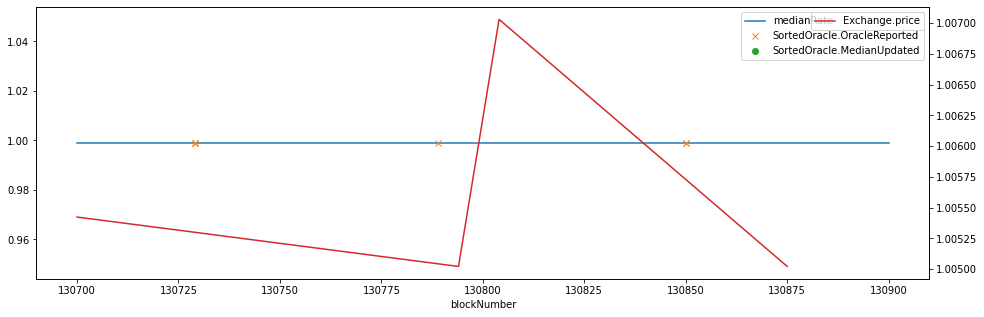

In [28]:
SortedOraclesAddress = '0x91061bF2F509AF76aa01F46E9F3E97577a5a80BA'
OracleReported = '0xdbf09271932e018b9c31e9988e4fbe3109fdd79d78f5d19a764dfb56035ed775'
MedianUpdated = '0x01f3db74cdcb3b158f2144fb78c5ab54e9e8a8c09d3d3b7713050cdb6b6bcb97'
Exchange = '0xC8FD77490A12F46709BffbCC0FCe35740Da8D860'
Exchanged = '0x402ac9185b4616422c2794bf5b118bfcc68ed496d52c0d9841dfa114fdeb05ba'

def filter_event(_df, event, arg='topic'):
    df_event_matches = _df[_df[arg] == event]
    return df_event_matches \
        .merge(df_events, left_on='blockNumber', right_on='blockNumber', suffixes=('_receipt', '')) \
        .merge(df_state, left_on='blockNumber', right_on='blockNumber', suffixes=('', '_state'))

df_report = filter_event(df_receipt, OracleReported)
df_median = filter_event(df_receipt, MedianUpdated)
df_exchanged = filter_event(df_receipt, Exchanged)

df_price = df_buy_sellusd[df_buy_sellusd.index>=window_min]
df_price = df_price[df_price.index<=window_max]
df_price = df_price[df_price.sellamount>0]
price_exchange = df_price.sellamount/df_price.buyamount

df_exchangers = df_exchanged.groupby('from_receipt').count().sort_values(by='blockNumber', ascending=False)
top_exchanger = df_exchangers.index[0] if len(df_exchangers.index) else None

df_active_trader = filter_event(df_receipt, top_exchanger, 'from')
df_active_trader = df_active_trader[df_active_trader.sellamount>0]
fig, ax = plt.subplots()
df_state.set_index('blockNumber').currentStableBucket.plot(ax=ax)
df_state.set_index('blockNumber').currentGoldBucket.plot(ax=ax, marker=".", color='gold')
df_active_trader.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="d", linestyle='None', label="most active trader", color="cyan")
df_report.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="x", ms=13, linestyle='None', label="SortedOracle.OracleReported")
df_median.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="o", ms=13, linestyle='None', label="SortedOracle.MedianUpdated")
df_exchanged.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker=".", linestyle='None', label="Exchange.Exchanged", color="magenta")
df_volumes = df_exchanged.set_index('blockNumber')
df_volumes = df_volumes[df_volumes.sellamount>0]
(df_volumes.currentStableBucket - df_volumes.sellamount).plot(ax=ax, marker="^", linestyle='None', color="black", label="currentStableBucket minus sellAmount")
price_exchange.plot(ax=ax, secondary_y=True, label='Exchange.price')
[ax.legend(loc=1) for ax in plt.gcf().axes]

fig, ax = plt.subplots()
df_state.set_index('blockNumber').medianRate.plot(ax=ax)
df_report.set_index('blockNumber').medianRate.plot(ax=ax, marker="x", linestyle='None', label="SortedOracle.OracleReported")
df_median.set_index('blockNumber').medianRate.plot(ax=ax, marker="o", linestyle='None', label="SortedOracle.MedianUpdated")
price_exchange.plot(ax=ax, secondary_y=True, label='Exchange.price')
[ax.legend(loc=1) for ax in plt.gcf().axes]

In [25]:
df_exchangers.head()

,blockNumber,address_receipt,topic,address,eventName,identifier,addr,identifierhash,slasheridentifier,account,...,medianRate_state,currentStableBucket_state,currentGoldBucket_state,goldTokenTotalSupply_state,timestamp_block_state,gasUsed_state,gasLimit_state,txAmount_state,blocktime_state,datetime_block_state
from_receipt,,,,,,,,,,,,,,,,,,,,,
0x8fb800b94d2b1258236e598fcd5e65eaf45ca671,112,112,112,112,112,0,0,0,0,0,...,112,112,112,112,112,112,112,112,16,112
0x73b49da41223585a650712363ba7878ed60a964d,6,6,6,6,6,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
0xd6f05649c5350c20030de1dc57ed31510141f487,4,4,4,4,4,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


In [26]:
df_blocks[100:105]


,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
100,1.579356e+09,130800.0,210780.0,20000000.0,4,5.0
101,1.579356e+09,130799.0,188089.0,20000000.0,1,5.0
102,1.579356e+09,130798.0,0.0,20000000.0,1,5.0
103,1.579356e+09,130797.0,161501.0,20000000.0,1,5.0
104,1.579356e+09,130796.0,149795.0,20000000.0,1,5.0


In [27]:
9.870084144948789e+25

9.870084144948789e+25